In [3]:
import pandas as pd
import numpy as np
import scipy
from statsmodels.tsa import stattools

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from ssm_stats import EsmssmStats
stats = EsmssmStats()
from ssm_prep_data import EsmssmDataPrep
prep = EsmssmDataPrep()
from ssm_plotting import EsmssmPlotting
plotting = EsmssmPlotting()

# Define filepath
filepath = '/../../results/modelfits/'

# Define path to save figures
figpath = '../../results/paper_figures/'
savefig = False

In [4]:
# Load modelfit for each subject
mat = scipy.io.loadmat(filepath + 'leemput/ssmfit.mat')

mood_columns = ['cheerful', 'content', 'anxious', 'sad']

In [5]:
Nsj = len(mat['fit'][0])
data = []

for i in range(Nsj):
    subdata = dict()
    # Extract parameter estimates
    subdata['timing'] = mat['fit'][0][i][0][0][2]
    subdata['data'] = mat['fit'][0][i][0][0][3]
    subdata['A'] = mat['fit'][0][i][0][0][5]['A'][0][0] + mat['fit'][0][i][0][0][5]['W'][0][0]
    subdata['bias'] = mat['fit'][0][i][0][0][5]['h'][0][0]
    subdata['latents'] = mat['fit'][0][i][0][0][5]['z'][0][0]
    subdata['dynamics'] = dict()
    subdata['dynamics']['val'], subdata['dynamics']['vec'] = stats.eig_dynamics_features(subdata['A'])
    # Run KF simulation
    subdata['KF_simulation'] = np.squeeze(stats.simulate_KF(subdata['data'][0,:], mat['fit'][0][i][0][0][5])[subdata['timing']-1,:])
    subdata['mse'] = np.mean((subdata['data'][:,subdata['timing']-1].T - subdata['KF_simulation'])**2,1)
    
    try:
        # Run VAR simulation
        varresults, varforcast = stats.fit_simulate_var(subdata['data'][:,~np.isnan(subdata['data'][0,:])].T)
        subdata['VAR'] = varresults.coefs
        subdata['VAR_simulation'] = varforcast
        subdata['mse_var'] = np.mean((subdata['data'][:,subdata['timing']-1].T - subdata['VAR_simulation'])**2,1)
    except:
        subdata['VAR'] = np.nan 
        subdata['VAR_simulation'] = np.full((len(subdata['timing']),4),np.nan)
        subdata['mse_var'] = np.full((1,4),np.nan)
        
    data.append(subdata)

In [6]:
# Infer key characeristics of empirical data, KF simulations and VAR simulations
key_char, key_char_kf, key_char_var = [],[], []
for i in range(Nsj):
    key_char.append(prep.basic_mood_dynamics(np.squeeze(data[i]['data'][:,data[i]['timing']-1])))
    key_char_kf.append(prep.basic_mood_dynamics(data[i]['KF_simulation'].T))
    key_char_var.append(prep.basic_mood_dynamics(data[i]['VAR_simulation'].T))

/Users/jolandamalamud/phd/papers/git/esmssm_public/code/python/ssm_prep_data.py:226: RuntimeWarning: Mean of empty slice
  basics['mean'] = np.nanmean(data,axis=1)
/Users/jolandamalamud/phd/papers/git/esmssm_public/code/python/ssm_prep_data.py:227: RuntimeWarning: Degrees of freedom <= 0 for slice.
  basics['variance'] = np.nanvar(data,axis=1)
/Users/jolandamalamud/phd/papers/git/esmssm_public/code/python/ssm_prep_data.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice.
  if np.nanvar(data) == 0: return np.nan
/Users/jolandamalamud/phd/papers/git/esmssm_public/code/python/ssm_prep_data.py:218: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  s = skew(data, axis=0, bias=True)
/Users/jolandamalamud/phd/papers/git/esmssm_public/code/python/ssm_prep_data.py:219: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This

In [7]:
# Extract key features for plot
mm = dict()
cc = dict()
rr = dict()
aa = dict()
bb = dict()
keys =['true', 'kf', 'var']
for p, kc in enumerate([key_char, key_char_kf, key_char_var]):
    key = keys[p]
    mm[key] = np.squeeze([kc[i]['mean'] for i in range(Nsj)]).T
    cc[key] = np.array([kc[i]['covariance'] for i in range(Nsj)]).T
    rr[key] = np.array([kc[i]['RMSSD'] for i in range(Nsj)]).T
    aa[key] = np.array([kc[i]['AR'] for i in range(Nsj)]).T
    bb[key] = np.array([kc[i]['bc'] for i in range(Nsj)]).T

In [8]:
# Autocorrelation for different lags
ar_lags = dict(true = [], kf = [], var = [])
for i in range(Nsj): 
    ar_coeff_sub,ar_coeff_sub_kf, ar_coeff_sub_var = [], [], []
    for j in range(len(mood_columns)):
        ar_coeff_sub.append(stattools.acf(data[i]['data'][j,data[i]['timing']-1], nlags=20))
        ar_coeff_sub_kf.append(stattools.acf(data[i]['KF_simulation'][:,j], nlags=20))
        ar_coeff_sub_var.append(stattools.acf(data[i]['VAR_simulation'][:,j], nlags=20))
    ar_lags['true'].append(ar_coeff_sub)
    ar_lags['kf'].append(ar_coeff_sub_kf)
    ar_lags['var'].append(ar_coeff_sub_var)

/Users/jolandamalamud/opt/miniconda3/envs/esmssm/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:691: RuntimeWarning: invalid value encountered in divide
  acf = avf[: nlags + 1] / avf[0]


KF cheerful mean: PearsonRResult(statistic=0.985903784905362, pvalue=1.991401303421416e-254)
VAR cheerful mean: PearsonRResult(statistic=0.9937395873245628, pvalue=1.5579532211136327e-188)
KF content mean: PearsonRResult(statistic=0.9837773552589462, pvalue=1.380681773621377e-244)
VAR content mean: PearsonRResult(statistic=0.9934065818384157, pvalue=2.4622923518288336e-186)
KF anxious mean: PearsonRResult(statistic=0.9815240604437457, pvalue=1.736476331429226e-235)
VAR anxious mean: PearsonRResult(statistic=0.9915320948035273, pvalue=1.0030366116428477e-175)
KF sad mean: PearsonRResult(statistic=0.9831945704351841, pvalue=4.0776247220815175e-242)
VAR sad mean: PearsonRResult(statistic=0.9933644171073481, pvalue=4.5895125371386825e-186)
KF cheerful inertia: PearsonRResult(statistic=0.6740611701202066, pvalue=3.9056351954844945e-44)
VAR cheerful inertia: PearsonRResult(statistic=0.07821719540546564, pvalue=0.27337476505315544)
KF content inertia: PearsonRResult(statistic=0.58621857363253

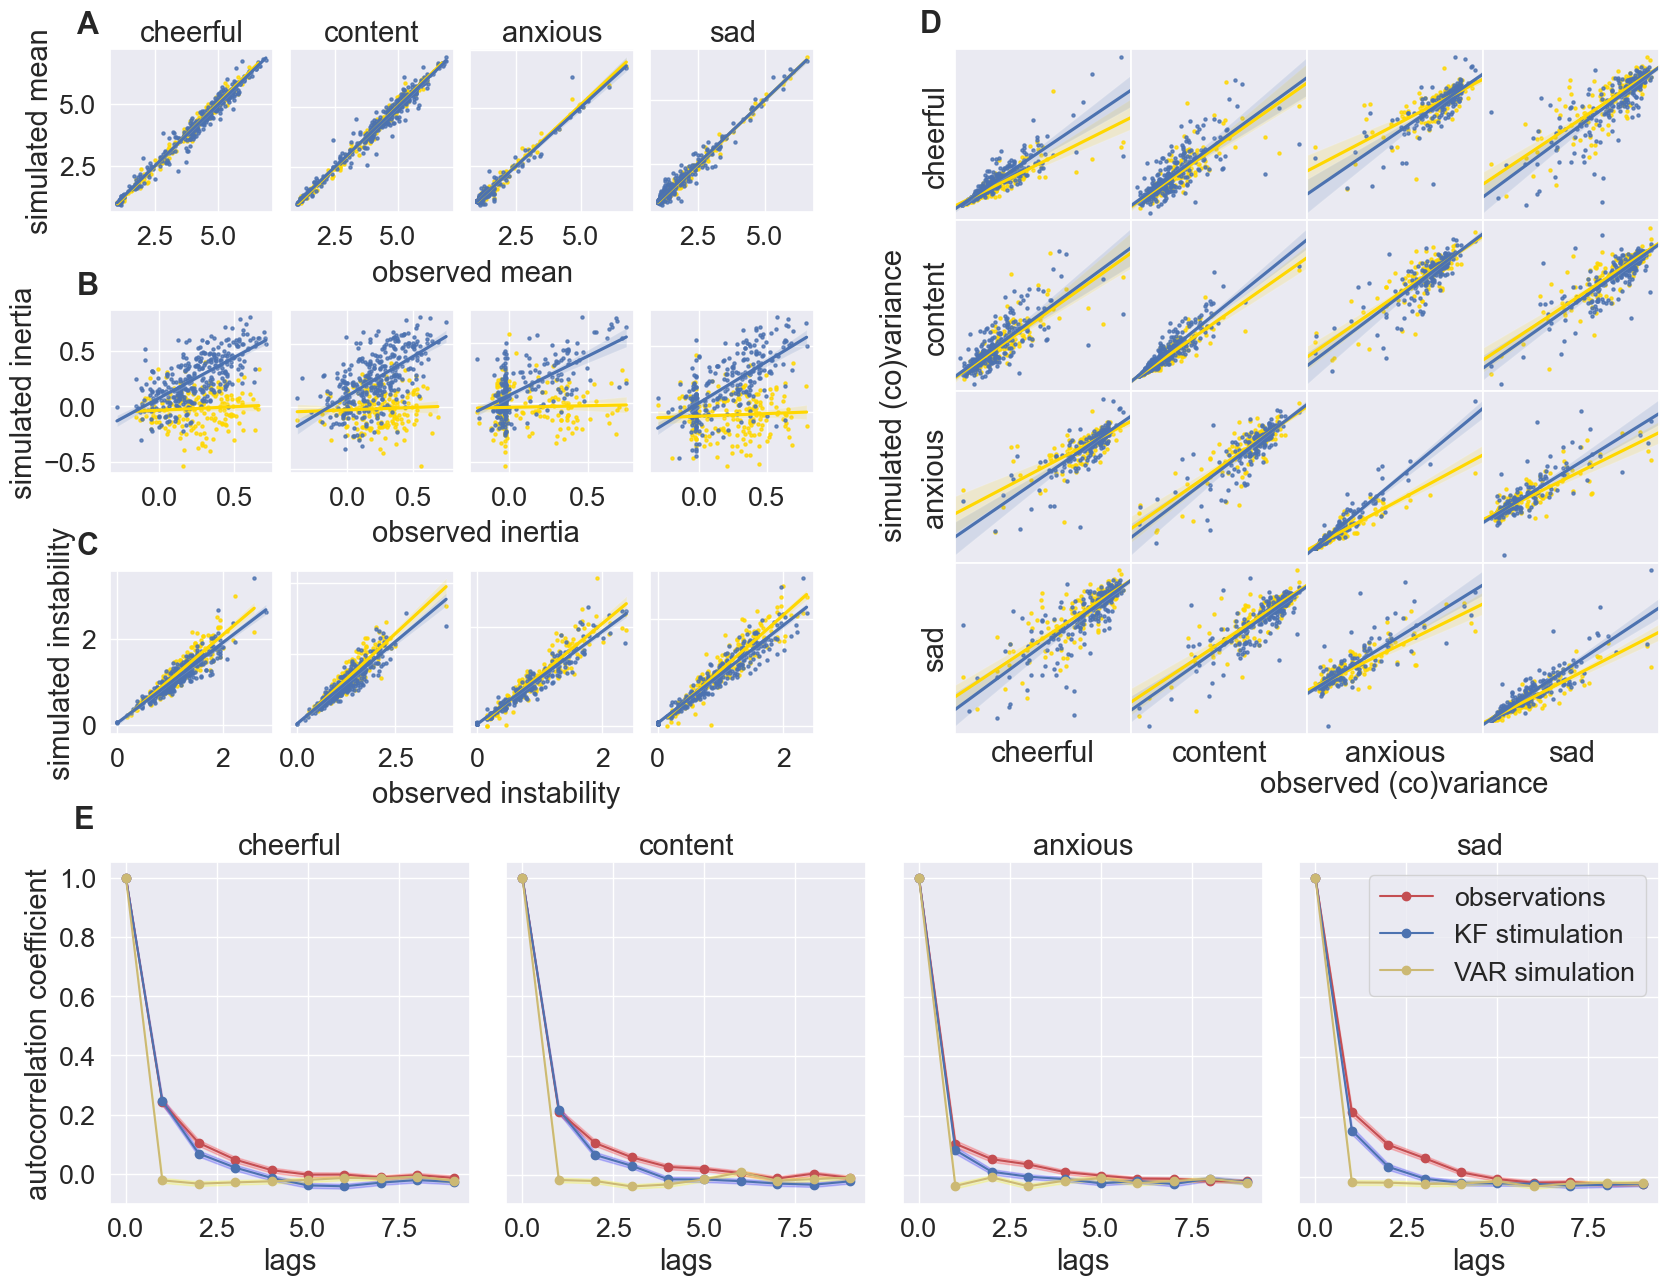

In [9]:
# Plot key features for empirical data, KF simulations and VAR simulations
def print_stats(data1, data2, name):
    isnonnan = ~np.isnan(data1) & ~np.isnan(data2)
    print(name + str(scipy.stats.pearsonr(data1[isnonnan], data2[isnonnan])))
      

sns.set(font_scale=1.75)
fig = plt.figure(figsize=(20, 15))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.25, height_ratios=(2,1))

# Plot mean, autocorrelation, and RMSSD of empirical vs simulated data
inner = gridspec.GridSpecFromSubplotSpec(3, 4, subplot_spec=outer[0,0],
                                         wspace=0.1, hspace=0.6)

p_label = ['mean', 'inertia', 'instability']
for j,p in enumerate([mm, aa ,rr]):
    ax = fig.add_subplot(inner[j,0])
    ax.text(-0.2,1.1, ['A', 'B', 'C'][j], weight='bold', size=22)
    ax.text(1.6,-0.42, 'observed ' + p_label[j])
    ax.set_axis_off()
    axs = None
    for i in range(len(mood_columns)):
        ax = plt.Subplot(fig, inner[j,i])
        ax = fig.add_subplot(ax, sharey=axs, sharex=axs)
        var_nonnan = ~np.isnan(p['var'][i,:])
        sns.regplot(x=p['true'][i,:], y=p['var'][i,:], ax=ax, scatter_kws={'s':5, 'marker':'+'}, color='gold')
        sns.regplot(x=p['true'][i,:], y=p['kf'][i,:], ax=ax, scatter_kws={'s':5, 'marker':'o'})
        if j == 0: ax.set(title=mood_columns[i])
        if i != 0: ax.set(yticklabels=[])
        if i == 0: ax.set(ylabel='simulated ' + p_label[j])
        print_stats(p['true'][i,:], p['kf'][i,:], 'KF ' + mood_columns[i] + ' ' + p_label[j] + ': ')
        print_stats(p['true'][i,:], p['var'][i,:], 'VAR ' + mood_columns[i] + ' ' + p_label[j] + ': ')
        axs = ax

# Plot covariance elements of empirical vs simulated data
inner = gridspec.GridSpecFromSubplotSpec(4, 4, subplot_spec=outer[0,1],
                                         wspace=0, hspace=0)
ax = fig.add_subplot(inner[0,0])
ax.text(-0.2,1.1, 'D', weight='bold', size=22)
ax.set_axis_off()
plotting.covariance_plot(cc, fig, inner, mood_columns)
fig.text(0.7,0.39,'observed (co)variance', va='center');
fig.text(0.51,0.65,'simulated (co)variance', rotation=90, va='center');
for i in range(len(mood_columns)):
    for j in range(len(mood_columns)):
        print_stats(cc['true'][i,j,:], cc['kf'][i,j,:], 'KF ' + mood_columns[i] + ' cov: ')
        print_stats(cc['true'][i,j,:], cc['var'][i,j,:], 'VAR ' + mood_columns[i] + ' cov: ')

# Plot autocorrelation over lags of empirical and simulated data
inner = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=outer[1,:],
                                         wspace=0.1, hspace=0)
ax = fig.add_subplot(inner[0,0])
ax.text(-0.2/2,1.1, 'E', weight='bold', size=22)
ax.set_axis_off()
plotting.ar_plot(ar_lags, fig, inner, mood_columns)
if savefig: plt.savefig(figpath + 'malamud_fig4_keyfeatures.svg', bbox_inches='tight')

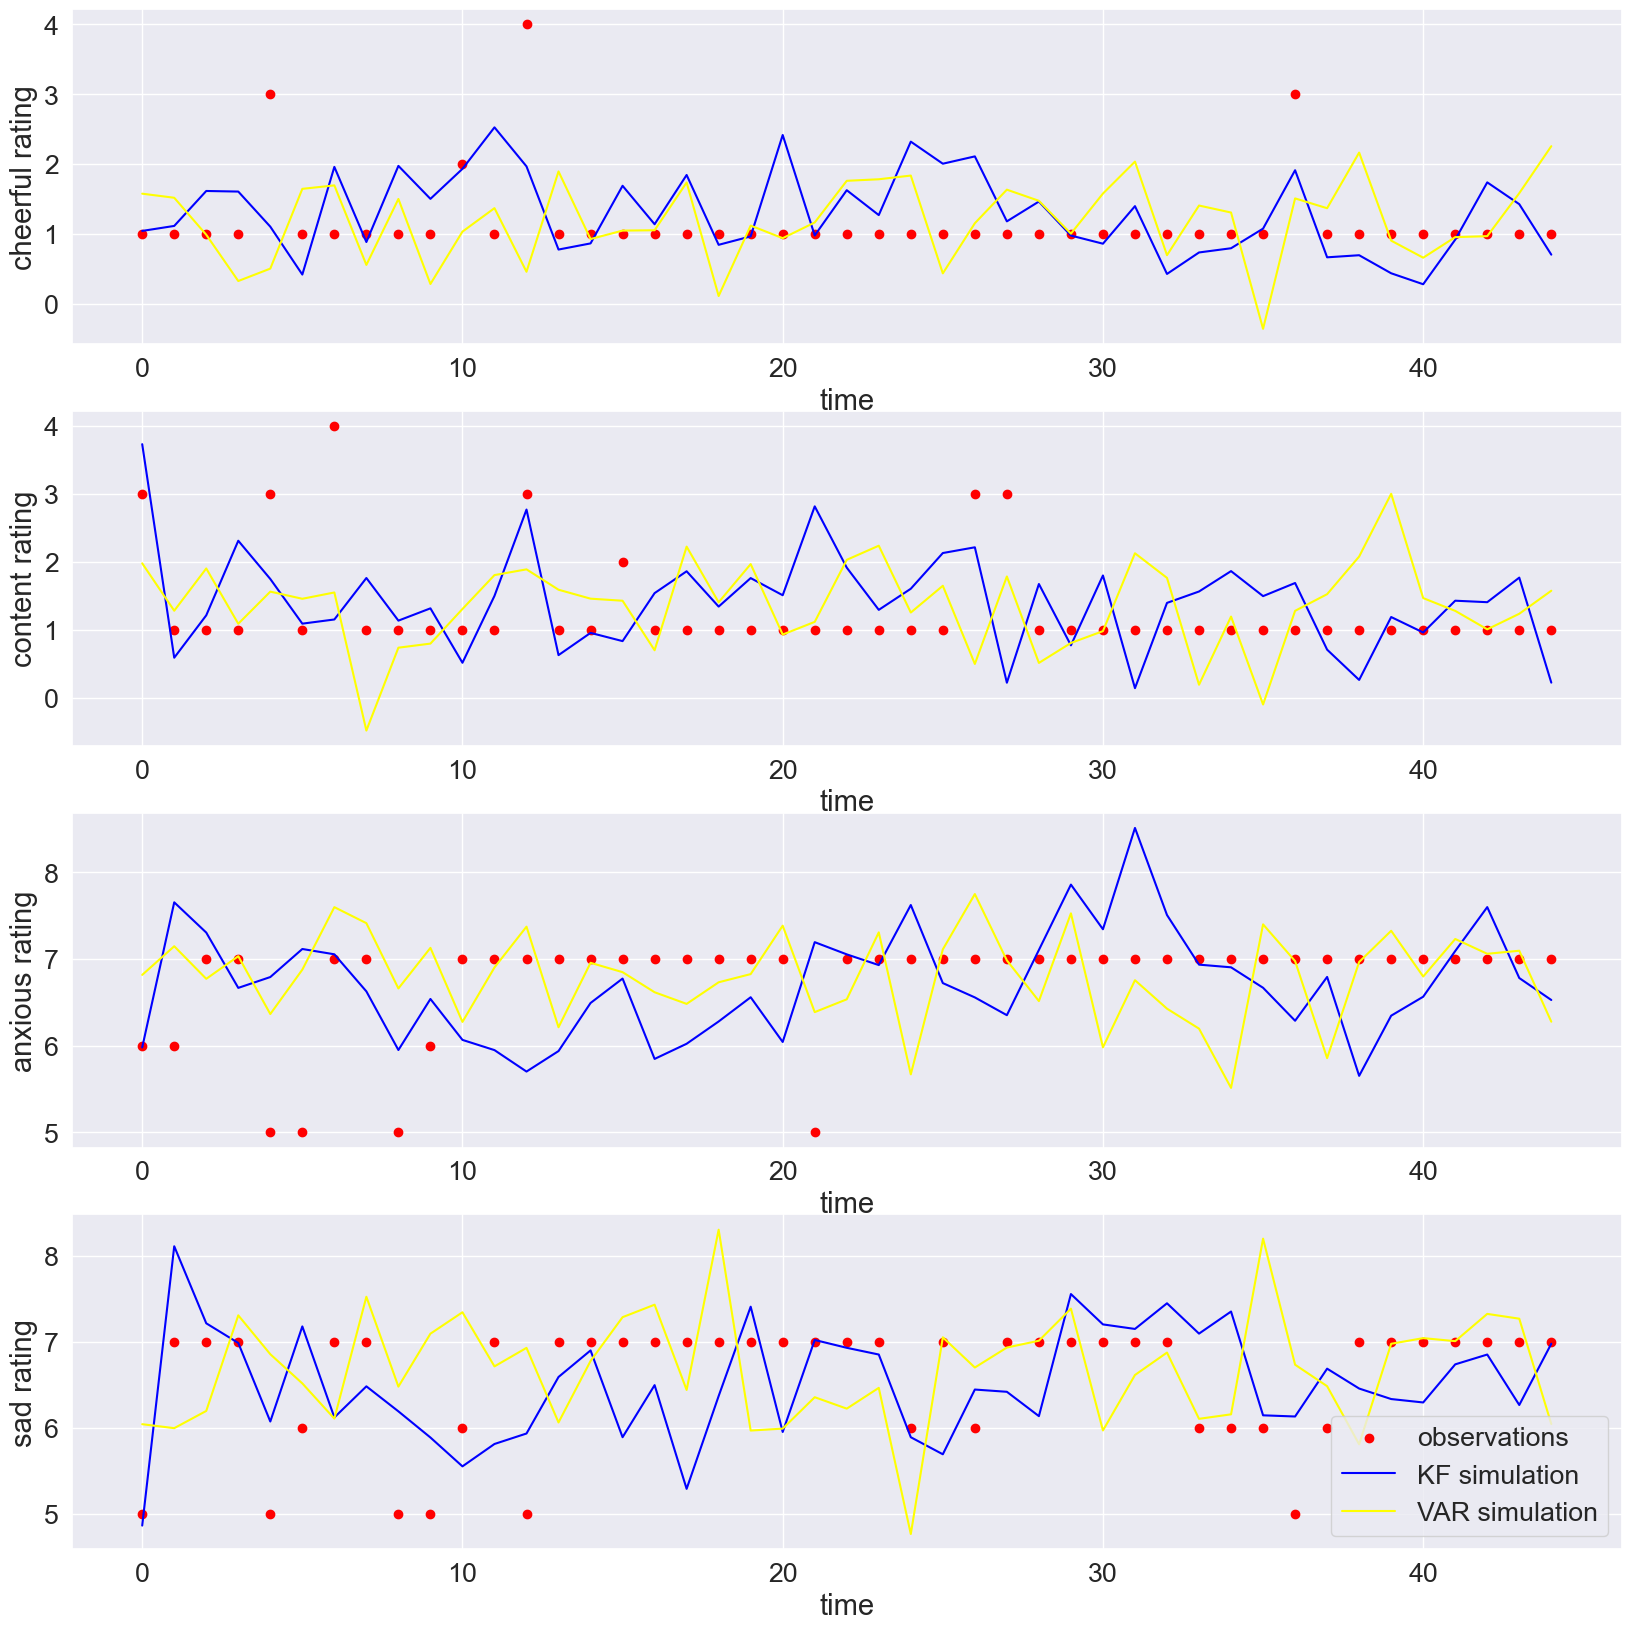

In [10]:
# Plot empirical and simulated (KF and VAR) data over time
s = 1 # Define subject
fig,axs = plt.subplots(4,1,figsize=(20,20))
for i in range(len(mood_columns)):
    axs[i].scatter(np.arange(len(data[s]['timing'])), data[s]['data'][i,data[s]['timing']-1], color='red')
    axs[i].plot(data[s]['KF_simulation'][:,i], color='blue')
    axs[i].plot(data[s]['VAR_simulation'][:,i], color='yellow')
    axs[i].set(ylabel=mood_columns[i] + ' rating', xlabel='time')
plt.legend(['observations', 'KF simulation', 'VAR simulation']);